In [2]:
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import df_shrink
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import make_pipeline
import pickle
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('/content/TON_IOT_pre.unknown')
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_0,IPV4_SRC_ADDR_1,IPV4_SRC_ADDR_2,IPV4_SRC_ADDR_3,IPV4_DST_ADDR_0,IPV4_DST_ADDR_1,IPV4_DST_ADDR_2,IPV4_DST_ADDR_3
0,63318,443,6,91.00,181,165,2,1,24,327,0,Benign,192,168,1,195,52,139,250,253
1,57442,15600,17,0.00,63,0,1,0,0,0,0,Benign,192,168,1,79,192,168,1,255
2,57452,15600,17,0.00,63,0,1,0,0,0,0,Benign,192,168,1,79,239,255,255,250
3,51989,15600,17,0.00,63,0,1,0,0,0,0,Benign,192,168,1,79,192,168,1,255
4,53927,1900,17,153.12,459,0,3,0,0,614,0,Benign,192,168,1,6,239,255,255,250


In [4]:
df = df[df['Attack']!="Benign"]

In [5]:
df = df_shrink(df, obj2cat=False, int2uint=False)

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

L4_SRC_PORT                   0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Label                         0
Attack                        0
IPV4_SRC_ADDR_0               0
IPV4_SRC_ADDR_1               0
IPV4_SRC_ADDR_2               0
IPV4_SRC_ADDR_3               0
IPV4_DST_ADDR_0               0
IPV4_DST_ADDR_1               0
IPV4_DST_ADDR_2               0
IPV4_DST_ADDR_3               0
dtype: int64

In [8]:
X = df.drop(columns='Attack')
y = df['Attack']

In [9]:
from imblearn.over_sampling import ADASYN

In [10]:
oversample = ADASYN()

In [11]:
X, y = oversample.fit_resample(X, y)

In [12]:
print(X.shape)
print(y.shape)

(4191440, 19)
(4191440,)


In [13]:
import pickle
with open('ADASYN-multi.pkl', 'wb') as f:
    pickle.dump(oversample, f)

In [14]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [16]:
pca = PCA(n_components = 10)
x10D = pca.fit_transform(X)
x10D = pd.DataFrame(x10D)
x10D.head(1)

,0,1,2,3,4,5,6,7,8,9
0,-1939.596402,231.945914,-14466.750476,2640.054183,183.369419,-106.031449,-4.628325,52.730913,-7.284201,1.597527


In [17]:
pca.components_.T[:,0]

array([ 1.78353655e-02,  1.14470844e-02, -2.23118516e-05,  1.45076540e-04,
        9.24502392e-02,  9.93425458e-01,  9.50795955e-04,  9.74710537e-04,
        6.33252274e-05,  6.40906111e-02, -0.00000000e+00, -1.96484763e-10,
        7.62802898e-11, -1.53249260e-09,  3.10784890e-04, -1.79761506e-04,
       -1.90626017e-05,  2.03120251e-04, -1.41262697e-04])

these are the first principle component contents

In [18]:
 pca.explained_variance_ratio_

array([5.41197763e-01, 2.12649433e-01, 1.53085281e-01, 8.84998675e-02,
       4.53639786e-03, 1.48915299e-05, 6.36004701e-06, 5.83443724e-06,
       1.67720684e-06, 1.20921571e-06])

In [19]:
pca = PCA(n_components = 10)
x10D = pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.54119776, 0.7538472 , 0.90693248, 0.99543234, 0.99996874,
       0.99998363, 0.99998999, 0.99999583, 0.99999751, 0.99999871])

Every attribute gave us the enough varianve that we need to start our model , so It will be enough to choose only those 10 principle components to represent the rest of the dataset

In [20]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

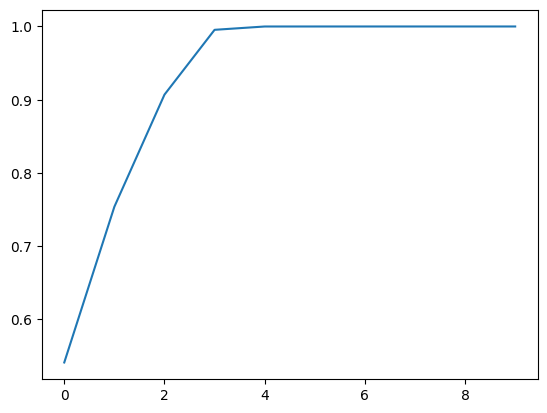

In [21]:
plt.plot(cumsum)

An elbow methods one of the techniques that could prove my prespective

In [22]:
pca = PCA(n_components = 6)
x10D = pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.54119776, 0.7538472 , 0.90693248, 0.99543234, 0.99996874,
       0.99998363])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998115 entries, 8 to 1210788
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   L4_SRC_PORT                 998115 non-null  int32  
 1   L4_DST_PORT                 998115 non-null  int32  
 2   PROTOCOL                    998115 non-null  int8   
 3   L7_PROTO                    998115 non-null  float32
 4   IN_BYTES                    998115 non-null  int32  
 5   OUT_BYTES                   998115 non-null  int32  
 6   IN_PKTS                     998115 non-null  int16  
 7   OUT_PKTS                    998115 non-null  int16  
 8   TCP_FLAGS                   998115 non-null  int8   
 9   FLOW_DURATION_MILLISECONDS  998115 non-null  int32  
 10  Label                       998115 non-null  int8   
 11  Attack                      998115 non-null  object 
 12  IPV4_SRC_ADDR_0             998115 non-null  int16  
 13  IPV4_SRC_ADDR

In [24]:
import pickle
with open('PCA-ADASYN-multi.pkl', 'wb') as f:
    pickle.dump(oversample, f)

#Logistic Regression

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(x10D, y, test_size = 0.3, random_state = 0)

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)
test_predictions = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
model.intercept_

array([ 5.08860795e-05,  1.76038818e-05, -7.90745933e-05,  1.32575297e-05,
        6.91967231e-05,  1.53356763e-06, -5.21868180e-05, -1.94386117e-05,
       -1.77775871e-06])

In [28]:
model.coef_

array([[ 1.97373156e-04, -5.02762717e-04,  3.49413828e-04,
         3.80333596e-04,  1.39436396e-02, -1.37150581e-02],
       [-2.75809994e-04,  1.05236374e-04, -2.19847655e-04,
        -1.16032997e-03,  2.94471459e-03,  8.42809677e-03],
       [-2.65856209e-05,  1.46076421e-04, -4.31395195e-05,
         2.33954032e-04, -4.82209128e-03, -1.59960955e-02],
       [ 1.15697517e-04,  3.61923587e-05, -1.92416747e-04,
        -3.21508523e-04, -5.05458017e-03,  5.40873454e-03],
       [ 1.81909789e-04,  2.07438880e-04,  1.30749414e-04,
         1.90226206e-04,  3.55393495e-03, -1.84523587e-02],
       [-5.82276641e-05,  2.25760473e-05, -1.31240212e-04,
         1.83477930e-04, -8.37889971e-03,  1.26790392e-02],
       [ 6.90192164e-05, -2.36857649e-04,  3.97877310e-04,
         3.69488417e-04,  1.33321354e-02,  5.35001294e-03],
       [-2.31497050e-04,  1.44432169e-04, -1.69202635e-04,
        -1.95180432e-05, -7.63887237e-03,  7.66237366e-03],
       [ 2.81206510e-05,  7.76681162e-05, -1.221

In [29]:
preds = model.predict(X_test)

In [30]:
print(classification_report(Y_test,preds))

              precision    recall  f1-score   support

           0       0.32      0.11      0.16    139355
           1       0.29      0.12      0.17    143644
           2       0.40      1.00      0.58    138278
           3       0.42      0.14      0.21    138811
           4       0.64      0.19      0.29    139542
           5       0.28      0.80      0.42    146363
           6       0.62      0.99      0.77    139712
           7       0.41      0.25      0.31    139835
           8       0.46      0.00      0.01    131892

    accuracy                           0.40   1257432
   macro avg       0.43      0.40      0.32   1257432
weighted avg       0.43      0.40      0.32   1257432



In [31]:
import pickle
with open('Regression-pca-ADASYN-multi.pkl', 'wb') as f:
    pickle.dump(oversample, f)

#RandomForestClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier(n_estimators=10,max_features='auto',random_state=101)

In [34]:
model.fit(X_train,Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', n_estimators=10, random_state=101)

In [35]:
preds = model.predict(X_test)

In [36]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [37]:
print(classification_report(Y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    139355
           1       0.55      0.51      0.53    143644
           2       0.83      0.92      0.87    138278
           3       0.39      0.37      0.38    138811
           4       0.98      0.99      0.98    139542
           5       0.45      0.44      0.45    146363
           6       0.99      1.00      1.00    139712
           7       0.79      0.83      0.81    139835
           8       0.66      0.66      0.66    131892

    accuracy                           0.74   1257432
   macro avg       0.74      0.75      0.74   1257432
weighted avg       0.74      0.74      0.74   1257432



In [38]:
import pickle
with open('Random-pca-ADASYN-multi.pkl', 'wb') as f:
    pickle.dump(oversample, f)

#Catgboost

In [39]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.0 MB/s eta 0:00:00


In [40]:
import catboost as ctb
model =  ctb.CatBoostClassifier()
model.fit(X_train, Y_train)

Learning rate set to 0.118895
0:	learn: 1.9705009	total: 4.01s	remaining: 1h 6m 48s
1:	learn: 1.8406151	total: 7.77s	remaining: 1h 4m 39s
2:	learn: 1.7480716	total: 10.5s	remaining: 58m 26s
3:	learn: 1.6610425	total: 13.6s	remaining: 56m 30s
4:	learn: 1.5980974	total: 16.4s	remaining: 54m 32s
5:	learn: 1.5449476	total: 20.3s	remaining: 56m 10s
6:	learn: 1.4896454	total: 23.3s	remaining: 55m 10s
7:	learn: 1.4474373	total: 26.3s	remaining: 54m 19s
8:	learn: 1.4136291	total: 28.9s	remaining: 53m 3s
9:	learn: 1.3787953	total: 33.2s	remaining: 54m 46s
10:	learn: 1.3514471	total: 35.9s	remaining: 53m 50s
11:	learn: 1.3229769	total: 39s	remaining: 53m 28s
12:	learn: 1.3043349	total: 41.4s	remaining: 52m 25s
13:	learn: 1.2815696	total: 45.6s	remaining: 53m 28s
14:	learn: 1.2644699	total: 48.2s	remaining: 52m 47s
15:	learn: 1.2496668	total: 50.8s	remaining: 52m 3s
16:	learn: 1.2342379	total: 53.6s	remaining: 51m 41s
17:	learn: 1.2197517	total: 57.1s	remaining: 51m 52s
18:	learn: 1.2053886	total

In [41]:
y_pred= model.predict(X_test)
score = accuracy_score(Y_test, y_pred)
print("Accuracy:", score)
print(classification_report(Y_test,y_pred))

Accuracy: 0.6997626909447191
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    139355
           1       0.59      0.45      0.51    143644
           2       0.71      0.96      0.81    138278
           3       0.80      0.32      0.46    138811
           4       0.94      0.90      0.92    139542
           5       0.42      0.46      0.44    146363
           6       0.96      1.00      0.98    139712
           7       0.59      0.67      0.63    139835
           8       0.46      0.60      0.52    131892

    accuracy                           0.70   1257432
   macro avg       0.72      0.70      0.69   1257432
weighted avg       0.72      0.70      0.69   1257432



In [42]:
import pickle
with open('Catboost-pca-ADASYN-multi.pkl', 'wb') as f:
    pickle.dump(oversample, f)

In [43]:
df.to_csv('C:\\Users\\Fast\\Desktop\\Capstone\\PCA_SMOTE_MuLTI_nardeen.csv', index=False)

In [44]:
df = pd.read_csv('C:\\Users\\Fast\\Desktop\\Capstone\\PCA_SMOTE_MuLTI_nardeen.csv')
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_0,IPV4_SRC_ADDR_1,IPV4_SRC_ADDR_2,IPV4_SRC_ADDR_3,IPV4_DST_ADDR_0,IPV4_DST_ADDR_1,IPV4_DST_ADDR_2,IPV4_DST_ADDR_3
0,60641,53,17,5.0,108,108,2,2,0,4,1,dos,192,168,1,31,192,168,1,1
1,60641,53,17,5.0,108,108,2,2,0,4,1,injection,192,168,1,31,192,168,1,1
2,60641,53,17,5.0,108,108,2,2,0,4,1,ddos,192,168,1,31,192,168,1,1
3,38524,53,17,5.0,100,100,2,2,0,5,1,injection,192,168,1,31,192,168,1,1
4,38524,53,17,5.0,100,100,2,2,0,5,1,ddos,192,168,1,31,192,168,1,1
